## [E-10] CIFAR-10 이미지 생성하기 🧩
앞서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델 구조를 이용해 CIFAR-10 데이터를 생성하는 모델을 만들어보자. 몇 가지 달라지는 점이 있다. <br/>

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경된다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러 이미지로 변경된다. 시각화 과정에서 고려할 점이 있다.
- 입력 데이터 전체 차원이 3~4배 증가하며, 학습이 진행되는 양상이 다소 달라진다.

CIFAR-10 데이터셋에 대한 간략한 설명

### Step 1. 작업 환경 구성하기

In [1]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

### Step 2. 데이터셋 구성하기
CIFAR-10 데이터셋도 마찬가지로 `tf.keras` 안에 있는 `datasets`에 포함되어 있다. <br/>
- 마찬가지로 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요하지 않으므로 y값은 `_`(언더스코어)로 무시해주자.

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
(train_x, _), (test_x, _) = tf.keras.datasets.cifar10.load_data()

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

print(train_x.shape)

max pixel: 255
min pixel: 0
(50000, 32, 32, 3)


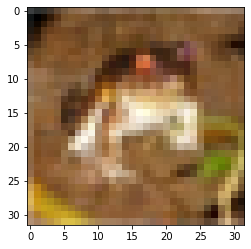

In [4]:
plt.imshow(train_x[0])
plt.show()

> 학습에 사용할 `train_x`의 이미지를 -1, 1로 정규화하자.

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


> 로드한 학습 데이터를 시각화를 통해 확인해보자. <br/>컬러이미지이므로 cmap='gray'를 할 필요 없다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


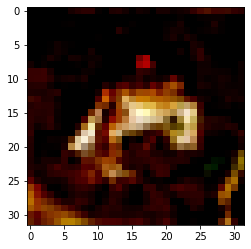

In [6]:
plt.imshow(train_x[0])
plt.show()

> imshow() 함수는 컬러 이미지의 경우 [0, 1] or [0, 255] 범위만 제대로 인식한다. 따라서 [-1, 1]로 변형한 이미지를 다시 1을 더하고 2로 나누어 [0, 1] 사이로 변형해야 원본대로 출력된다.

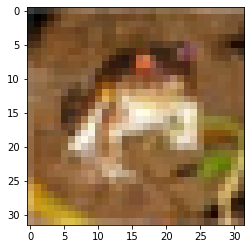

In [7]:
plt.imshow((train_x[0] + 1) / 2.0)
plt.show()

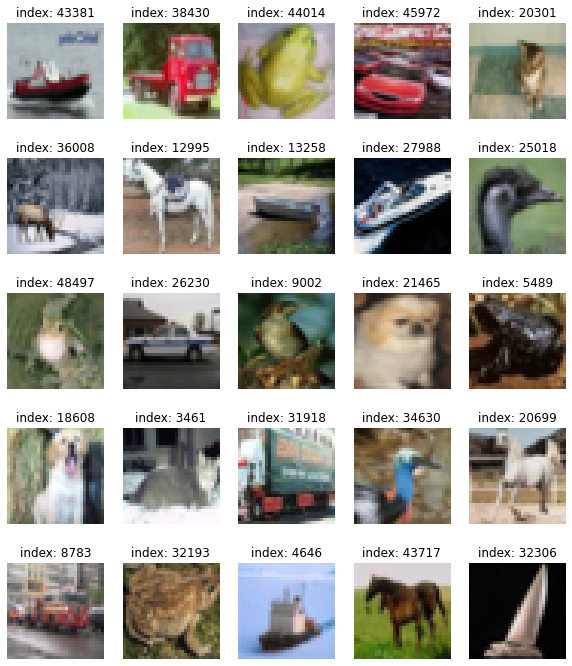

In [8]:
# train image 랜덤으로 설정
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

> tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용해 미니배치 데이터셋을 구성해자.

In [9]:
BUFFER_SIZE = 50000 # 전체 데이터 섞기 (데이터 사이즈와 같게(or 크게) 설정)
BATCH_SIZE = 256 # 한 번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

In [10]:
# def load_data(label=None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
#         df = df[df['label']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns =['image', 'label']) 
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

### Step 3. 생성자 모델 구현하기

> (32, 32, 3)의 shape을 가진 이미지를 생성하는 모델 구현 함수 작성하기

앞선 예제에선 `Conv2DTranspose` 층에서 `(7, 7, 256) -> (14, 14, 64) -> (28, 28, 1)` 형태로 이미지를 키워나갔다. <br/> <br/>

이번 예제는 (32, 32, 3)의 shape을 만들어야 한다. 따라서 `(4, 4, 256) -> (8, 8, 128) -> (16, 16, 64) -> (32, 32, 3)` 으로 키워나갈 수 있도록 하자.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 5: Conv2DTranspose layer    
    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

> `noise = tf.random.normal([1, 100])` 로 생성된 랜덤 노이즈를 입력으로 하여 구현한 생성자로 랜덤 이미지를 생성해보자.

In [12]:
noise = tf.random.normal([1, 100])

> 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해보자.

In [13]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [14]:
generated_image = generator(noise, training=False)  # 훈련 중이 아니므로 training=False
generated_image.shape

TensorShape([1, 32, 32, 3])

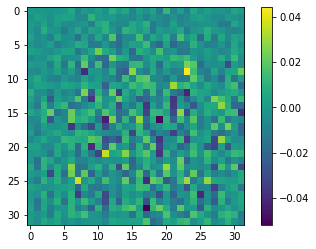

In [15]:
# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0, 3번째 인덱스는 0으로 설정
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### Step 4. 판별자 모델 구현하기

> (32, 32, 3)의 이미지를 입력으로 받아 1dim의 판별결과를 출력하는 판별자 모델 구현 함수 작성하기


`(32, 32, 3) ->(16, 16, 64) -> (8, 8, 128) -> (4, 4, 256) -> (2, 2, 512)`

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5),  strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 3: Conv2D Layer
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 4: Flatten Layer
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 5: Flatten Layer    
    model.add(layers.Flatten())

    # 6: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00055431]], dtype=float32)>

### Step 5. 손실함수와 최적화 함수 구현하기

> 생성자와 판별자의 손실함수(loss)를 구현하기

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# fake_output이 1에 가까울수록 (What generator wants) 작은 값을 가진다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
# real은 1에, fake는 0에 가깝길 원함.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

> 판별자의 출력값을 통해 accuracy를 계산하는 함수 구현하기

In [22]:
# 판별자 정확도 판별 - 둘 다 0.5에 가까운 것이 이상적이다.
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

> 생성자와 판별자를 최적화하는 optimizer 정의하기 -> 바꿔보자

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4, 0.5)

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### Step 6. 훈련과정 상세 기능 구현하기
> 1개 미니배치 훈련 과정 처리하는 `train_step()` 함수 구현하기

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

> 16개의 고정된 seed를 입력으로 해 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수 구현하기

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0])
        plt.imshow((predictions[i] + 1) / 2.0) # 역정규화를 하여 이미지를 출력
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

> 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history()` 함수를 구현해 봅시다.

In [27]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_2/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

> `training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [28]:
checkpoint_dir = '/aiffel/aiffel/dcgan_newimage/cifar10_2/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Step 7. 학습 과정 진행하기
> 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 60

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

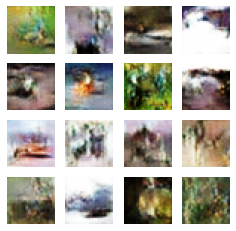

Time for training : 1514 sec


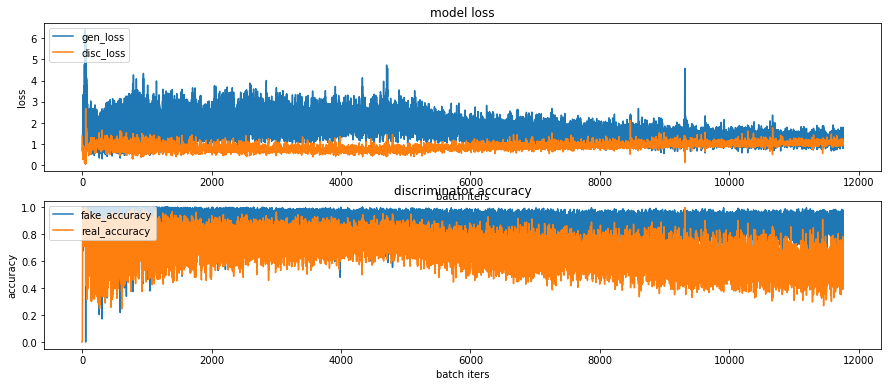

CPU times: user 25min 30s, sys: 1min 31s, total: 27min 2s
Wall time: 25min 15s


In [31]:
%%time

train(train_dataset, EPOCHS, save_every)
    
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

> 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

In [32]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/cifar10_dcgan11.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_2/cifar10_dcgan11.gif

-rw-r--r-- 1 root root 1151855 Feb 14 04:28 /aiffel/aiffel/dcgan_newimage/cifar10_2/cifar10_dcgan11.gif


In [33]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newi mage/cifar10_2/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

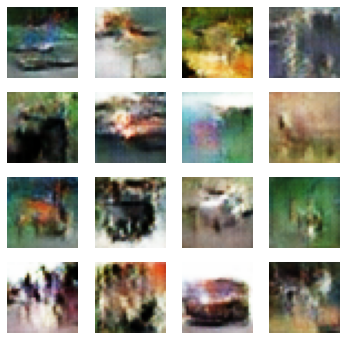

In [34]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인.
plt.figure(figsize=(6, 6))

for i in range(16):
    plt.subplot(4, 4, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   #역정규화를 하여 이미지를 출력
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()

****

## 성능 비교

### 🧩 1. Original
- 일단 예제 데이터와 입력 형식이 다르기 때문에 생성자 & 판별자 모델을 변경해야 했다. 생성자 모델에서 (32, 32, 3)을 출력하기 위해 strides를 조절했다.
- epoch=50
<br/>

🐙 생성된 이미지만 봐도 무슨 이미지인지 구별이 잘 안가지 않는다.

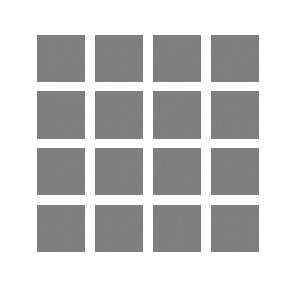

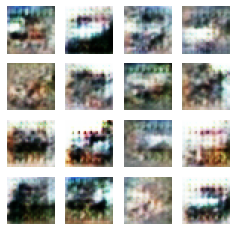
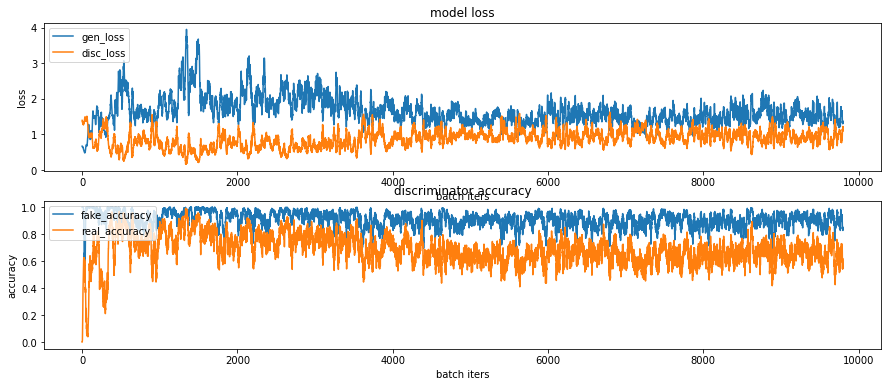

### 🧩 2. Conv2D layer를 추가로 몇 층 더 쌓아줌. 
### 🧩 2. learning rate: `tf.keras.optimizers.Adam(1e-4, 0.5)`
- fake_accuracy가 계속해서 0.8 ~ 1.0 사이에서만 움직여 하이퍼파라미터를 변경해보았다.
- Adam의 하이퍼파라미터는 총 3개인데, 첫 번째 값은 learning rate(α), 나머지 두 개는 일차 모멘텀용 계수(β1), 이차 모멘텀용 계수(β2)이다. 기본 설정값은 β1=0.9, β1=0.99이다.
- 모멘텀은 `운동량`을 뜻하는 단어로, 물리에서의 속도로 간주하며 **기울기 방향으로 힘을 받아 물체가 가속**되어 공이 구르는 듯한 움직임을 보인다. 기울어진 방향에 **마찰이나 공기저항을 제외하여** 뺀다.

<br/>

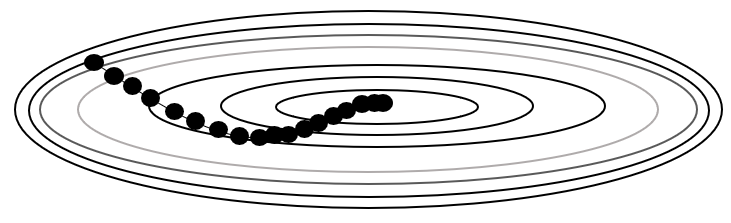
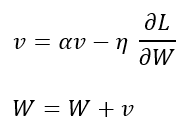

<br/>

- β1을 0.5로 변경(감소)해주었다.
- epoch=60
<br/>

🐙 loss값들이 확연히 줄어듬을 확인할 수 있다.

<br/>

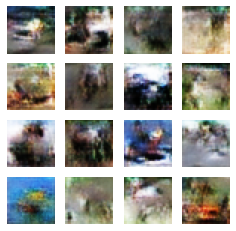
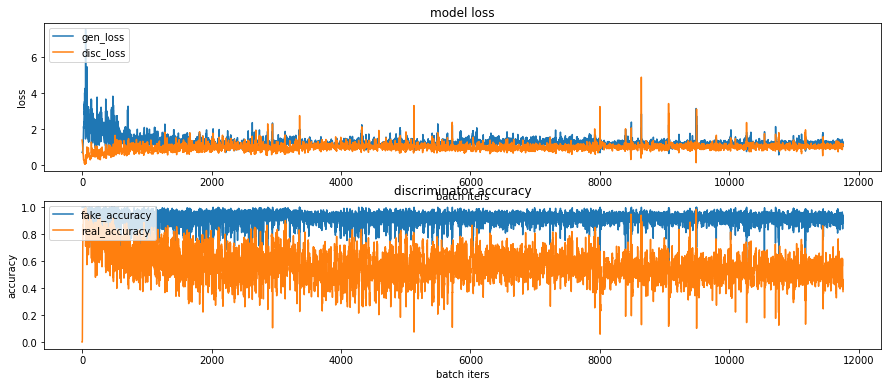

### 🧩 4. learning rate: `tf.keras.optimizers.Adam(1e-4, 0.2)`
- 일차 모멘텀용을 0.9 -> 0.5 -> 0.2로 변경해보았다.
<br/>

🐙 real accuracy가 떨어졌다. => **모멘텀 계수는 낮춘다고 좋은 것이 아니다.**

<br/>

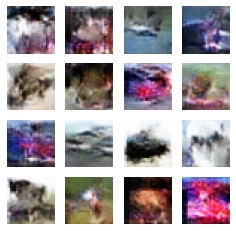
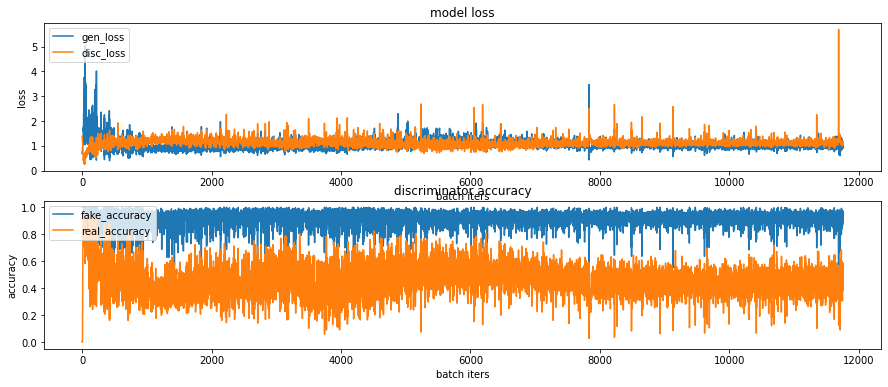

### 🧩 learning rate: `tf.keras.optimizers.Adam(2e-4, 0.5)`

- 2에서 learning rate는 2e-4로 2배 크게 조정해주었다.
- epoch=60
<br/>

🐙 정확성이 좀 높아졌다.

<br/>

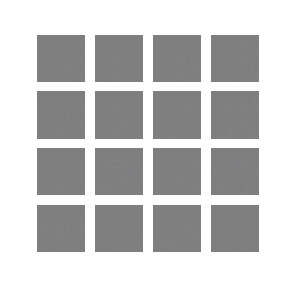

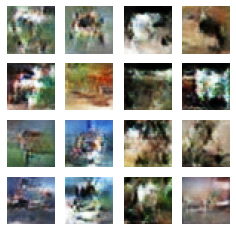
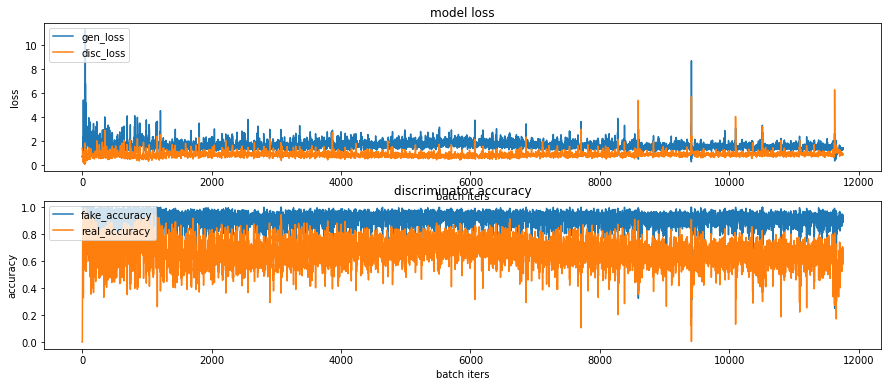

### 🧩 learning rate: `tf.keras.optimizers.RMSprop(2e-4, 0.5)`
- 2에서 learning rate는 2e-4로 변경해주었다.
- epoch=60
<br/>

🐙 판별자 모델의 loss은 높아지고 acc는 낮아졌다. => **생성자 모델에 RMSProp을 쓰면 좋지 않군**

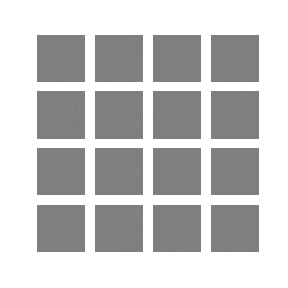

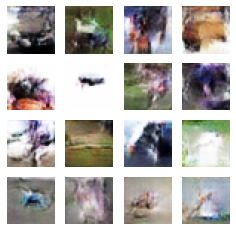

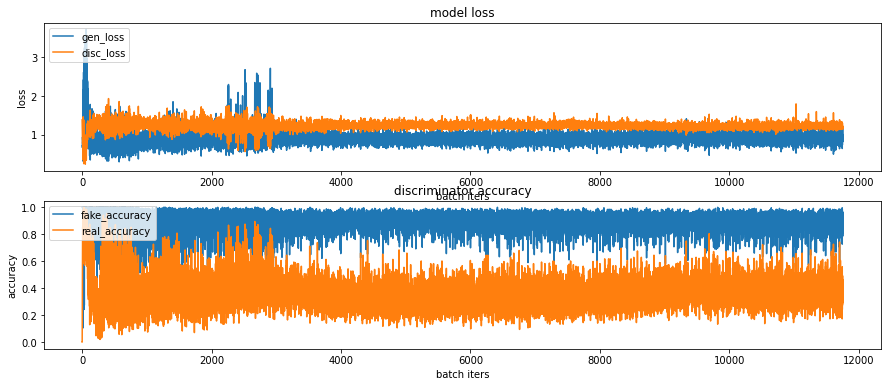

## 👍 찐 최종 결과 👍
### 🧩 생성자: `tf.keras.optimizers.Adam(2e-4, 0.5)`
### 🧩 판별자: `tf.keras.optimizers.RMSprop(2e-4, 0.5)`
- 생성자는 Adam을, 판별자는 RMSProp을 사용했다.
- 생성자 모두를 Adam 혹은 RMSProp 한 가지로 설정하였더니 이미지 생성이 제대로 이뤄지지 않았다.
<br/>

🐙 둘 모두를 Adam으로 설정했을 때보단 real_acc가 증가했고, 둘 모두를 RMSProp으로 설정했을 때보단 disc_loss가 감소했다. fake_acc도 상대적으로 넓은 폭으로 존재함을 확인할 수 있었다.

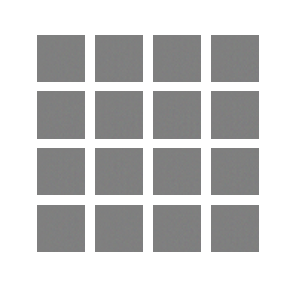

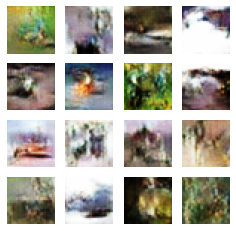
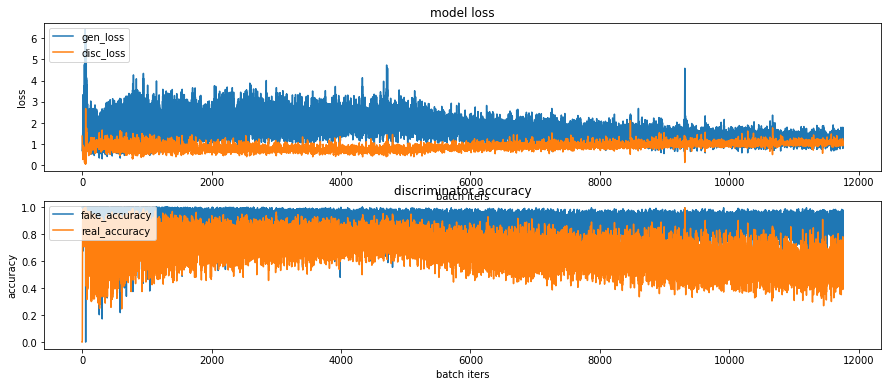

***

## 최종 회고
#### ✔️ 데이터 shape 변경
- 사실 데이터의 shape을 (28, 28, 1)에서 (32, 32, 3)으로 변경하는 부분이 꽤나 어려웠다. 아직 각 레이어들의 특성과 파라미터 수 계산 부분을 이해하지 못해 반드시 공부가 필요하다고 느꼈고, 이전 노드들을 참고해봐야겠다.

#### ✔️ layer 추가
- layer들을 몇 겹 더 쌓는 것만 해도 성능이 매우 향상된 양상을 보였다. 깊은 layer가 좋은 딥러닝 모델을 만든다는 의미를 경험 할 수 있었다.

#### ✔️ Adam & RMSProp
- 옵티마이저는 보통 성능이 가장 좋은 Adam 혹은 RMSProp으로 설정한다. 둘을 각각 다르게 설정했을 때 가장 좋은 결과가 나온 것 같고, 모델에 맞게 그 원인을 더 파악함이 요구된다.

#### ✔️ 하이퍼파라미터 변경
- 확실히 단순히 learning rate만 두는 것이 아닌 모멘텀형 계수도 변경하는 것이 더 좋은 성능을 보였다. 뿐만 아니라 learning rate를 1e-4에서 2e-4로 늘리는 것이 더 효과적이었고, 하이퍼 파라미터에 따른 성능 비교도 할 수 있어 유익했다.

#### ✔️ 아쉬웠던 점
- 생각보다 이미지들의 화질이 좋지 않게 나왔다. 그 원인이 무엇일지 아직 알아내지 못했다.
- 모델 부분에서 BatchNormalization, Dropout 부분도 지워보거나 하이퍼파라미터 변경을 통해 결과물들을 비교해보고싶었는데 시간 관계 상 진행하지 못해 아쉬웠다.